In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init

from flows import Planar
from models import NormalizingFlowModel

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Build the model

In [2]:
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(22, 96),
            nn.LeakyReLU(True),
            nn.Linear(96, 48),
            nn.LeakyReLU(True),            
            nn.Linear(48, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 48),
            nn.LeakyReLU(True),
            nn.Linear(48, 96),
            nn.LeakyReLU(True),
            nn.Linear(96, 22),
            nn.Sigmoid()
        )
        
        flow_init = Planar(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

In [3]:
N_EPOCHS = 20
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

N_FLOWS = 4
Z_DIM = 3

n_steps = 0

In [4]:
model = VAE_NF(N_FLOWS, Z_DIM).cuda()

## Testing with the trained model on signal

In [5]:
model.load_state_dict(torch.load("lhc_weights/bkg_vae_NF_planar_train_on_signal.h5"))

<All keys matched successfully>

In [6]:
def get_mass_and_loss(inputstring):
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    dt_in[:,1] = (dt_in[:,1]-np.mean(dt_in[:,1]))/np.std(dt_in[:,1])
    dt_in[:,2] = (dt_in[:,2]-np.mean(dt_in[:,2]))/np.std(dt_in[:,2])
    dt_in[:,3] = (dt_in[:,3]-np.mean(dt_in[:,3]))/np.std(dt_in[:,3])
    dt_in[:,4] = (dt_in[:,4]-np.mean(dt_in[:,4]))/np.std(dt_in[:,4])
    dt_in[:,5] = (dt_in[:,5]-np.mean(dt_in[:,5]))/np.std(dt_in[:,5])
    dt_in[:,6] = (dt_in[:,6]-np.mean(dt_in[:,6]))/np.std(dt_in[:,6])

    dt_in[:,8] = (dt_in[:,8]-np.mean(dt_in[:,8]))/np.std(dt_in[:,8])
    dt_in[:,9] = (dt_in[:,9]-np.mean(dt_in[:,9]))/np.std(dt_in[:,9])
    dt_in[:,10] = (dt_in[:,10]-np.mean(dt_in[:,10]))/np.std(dt_in[:,10])
    dt_in[:,11] = (dt_in[:,11]-np.mean(dt_in[:,11]))/np.std(dt_in[:,11])
    dt_in[:,12] = (dt_in[:,12]-np.mean(dt_in[:,12]))/np.std(dt_in[:,12])

    dt_in[:,14] = (dt_in[:,14]-np.mean(dt_in[:,14]))/np.std(dt_in[:,14])
    dt_in[:,15] = (dt_in[:,15]-np.mean(dt_in[:,15]))/np.std(dt_in[:,15])
    dt_in[:,16] = (dt_in[:,16]-np.mean(dt_in[:,16]))/np.std(dt_in[:,16])
    dt_in[:,17] = (dt_in[:,17]-np.mean(dt_in[:,17]))/np.std(dt_in[:,17])
    dt_in[:,18] = (dt_in[:,18]-np.mean(dt_in[:,18]))/np.std(dt_in[:,18])
    dt_in[:,19] = (dt_in[:,19]-np.mean(dt_in[:,19]))/np.std(dt_in[:,19])
    
    dt_in[:,21] = (dt_in[:,21]-np.mean(dt_in[:,21]))/np.std(dt_in[:,21])
    dt_in[:,22] = (dt_in[:,22]-np.mean(dt_in[:,22]))/np.std(dt_in[:,22])
    dt_in[:,23] = (dt_in[:,23]-np.mean(dt_in[:,23]))/np.std(dt_in[:,23])
    dt_in[:,24] = (dt_in[:,24]-np.mean(dt_in[:,24]))/np.std(dt_in[:,24])
    dt_in[:,25] = (dt_in[:,25]-np.mean(dt_in[:,25]))/np.std(dt_in[:,25])   
    
    total_in = torch.tensor(dt_in)
    total_in_train_x_1 = total_in.t()[1:7].t()
    total_in_train_x_2 = total_in.t()[8:13].t()
    total_in_train_x_3 = total_in.t()[14:20].t()
    total_in_train_x_4 = total_in.t()[21:26].t()
    total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_2,total_in_train_x_3,total_in_train_x_4),dim=1)
    
    with torch.no_grad():
        loss_total_in = torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    
    return dt_in[:,0], dt_in[:,10], dt_in[:,23], dt_in[:,9], dt_in[:,22], loss_total_in

In [7]:
bb2mass, bb2mmdt1, bb2mmdt2, bb2prun1,bb2prun2, bb2loss = get_mass_and_loss("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_BB1.h5")
purebkgmass, purebkgmmdt1, purebkgmmdt2, purebkgprun1,purebkgprun2, purebkgloss = get_mass_and_loss("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_RandD_signal.h5")

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


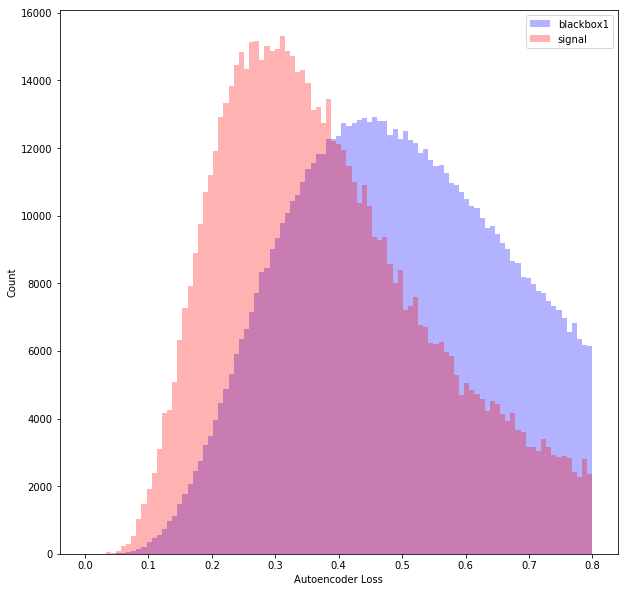

In [8]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,0.8,100)
n_bb, _, _ = plt.hist(bb2loss,bins=bins,alpha=0.3,color='b',label='blackbox1')
n_bkg, _, _ = plt.hist(purebkgloss,bins=bins,alpha=0.3,color='r',label='signal',weights=np.ones(len(purebkgloss))*10)
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [9]:
idx_signal = np.where(bb2loss<0.65)

## Testing with the trained model on bkg

In [10]:
model.load_state_dict(torch.load("lhc_weights/bkg_vae_NF_planar_train_on_bkg.h5"))

<All keys matched successfully>

In [11]:
def get_mass_and_loss(inputstring):
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    dt_in[:,1] = (dt_in[:,1]-np.mean(dt_in[:,1]))/np.std(dt_in[:,1])
    dt_in[:,2] = (dt_in[:,2]-np.mean(dt_in[:,2]))/np.std(dt_in[:,2])
    dt_in[:,3] = (dt_in[:,3]-np.mean(dt_in[:,3]))/np.std(dt_in[:,3])
    dt_in[:,4] = (dt_in[:,4]-np.mean(dt_in[:,4]))/np.std(dt_in[:,4])
    dt_in[:,5] = (dt_in[:,5]-np.mean(dt_in[:,5]))/np.std(dt_in[:,5])
    dt_in[:,6] = (dt_in[:,6]-np.mean(dt_in[:,6]))/np.std(dt_in[:,6])

    dt_in[:,8] = (dt_in[:,8]-np.mean(dt_in[:,8]))/np.std(dt_in[:,8])
    dt_in[:,9] = (dt_in[:,9]-np.mean(dt_in[:,9]))/np.std(dt_in[:,9])
    dt_in[:,10] = (dt_in[:,10]-np.mean(dt_in[:,10]))/np.std(dt_in[:,10])
    dt_in[:,11] = (dt_in[:,11]-np.mean(dt_in[:,11]))/np.std(dt_in[:,11])
    dt_in[:,12] = (dt_in[:,12]-np.mean(dt_in[:,12]))/np.std(dt_in[:,12])

    dt_in[:,14] = (dt_in[:,14]-np.mean(dt_in[:,14]))/np.std(dt_in[:,14])
    dt_in[:,15] = (dt_in[:,15]-np.mean(dt_in[:,15]))/np.std(dt_in[:,15])
    dt_in[:,16] = (dt_in[:,16]-np.mean(dt_in[:,16]))/np.std(dt_in[:,16])
    dt_in[:,17] = (dt_in[:,17]-np.mean(dt_in[:,17]))/np.std(dt_in[:,17])
    dt_in[:,18] = (dt_in[:,18]-np.mean(dt_in[:,18]))/np.std(dt_in[:,18])
    dt_in[:,19] = (dt_in[:,19]-np.mean(dt_in[:,19]))/np.std(dt_in[:,19])
    
    dt_in[:,21] = (dt_in[:,21]-np.mean(dt_in[:,21]))/np.std(dt_in[:,21])
    dt_in[:,22] = (dt_in[:,22]-np.mean(dt_in[:,22]))/np.std(dt_in[:,22])
    dt_in[:,23] = (dt_in[:,23]-np.mean(dt_in[:,23]))/np.std(dt_in[:,23])
    dt_in[:,24] = (dt_in[:,24]-np.mean(dt_in[:,24]))/np.std(dt_in[:,24])
    dt_in[:,25] = (dt_in[:,25]-np.mean(dt_in[:,25]))/np.std(dt_in[:,25])   
    
    total_in = torch.tensor(dt_in)
    total_in_train_x_1 = total_in.t()[1:7].t()
    total_in_train_x_2 = total_in.t()[8:13].t()
    total_in_train_x_3 = total_in.t()[14:20].t()
    total_in_train_x_4 = total_in.t()[21:26].t()
    total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_2,total_in_train_x_3,total_in_train_x_4),dim=1)
    
    with torch.no_grad():
        loss_total_in = torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    
    return dt_in[:,0], dt_in[:,10], dt_in[:,23], dt_in[:,9], dt_in[:,22], loss_total_in

In [12]:
bb2mass, bb2mmdt1, bb2mmdt2, bb2prun1,bb2prun2, bb2loss = get_mass_and_loss("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_BB1.h5")
purebkgmass, purebkgmmdt1, purebkgmmdt2, purebkgprun1,purebkgprun2, purebkgloss = get_mass_and_loss("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_pureBkg.h5")

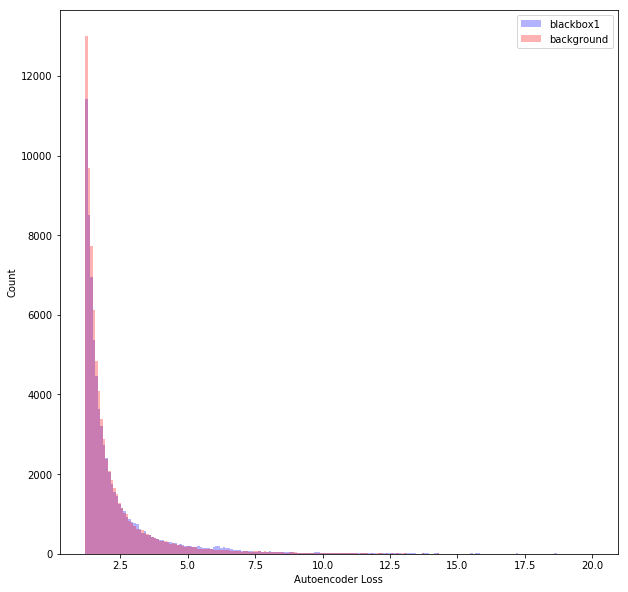

In [13]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(1.2,20,200)
n_bb, _, _ = plt.hist(bb2loss,bins=bins,alpha=0.3,color='b',label='blackbox1')
n_bkg, _, _ = plt.hist(purebkgloss,bins=bins,alpha=0.3,color='r',label='background')
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [34]:
idx_bkg = np.where(bb2loss>0.7)

In [35]:
len(idx_signal[0]),len(idx_bkg[0])

(600773, 277770)

In [36]:
idx = np.intersect1d(idx_bkg,idx_signal)
len(idx)

3811

## Plot remained data in BB

In [42]:
bb_data = pd.read_hdf("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_BB1.h5")
bb_data = bb_data.values

In [43]:
good_data = bb_data[idx]
mjj_good_data = good_data[:,0]

In [44]:
bkg_data = pd.read_hdf("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_pureBkg.h5")
bkg_data = bkg_data.values

In [45]:
good_bkg_data = bkg_data[idx]
mjj_good_bkg_data = good_bkg_data[:,0]

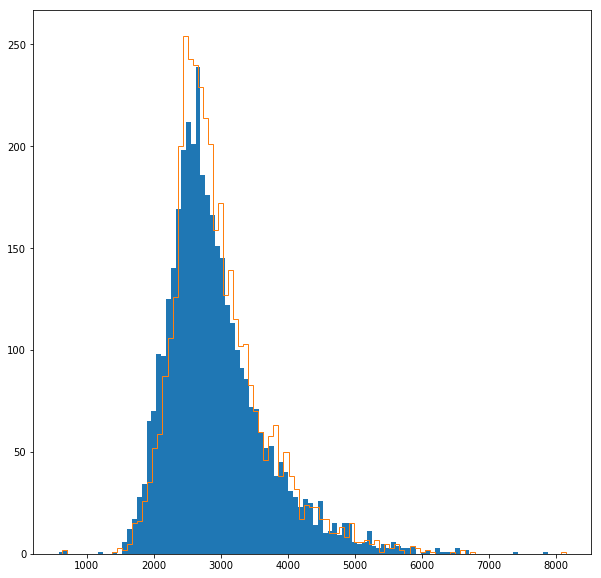

In [46]:
plt.hist(mjj_good_data,100);
plt.hist(mjj_good_bkg_data,100,histtype='step');